## import packges 

In [18]:
# -*- coding: utf-8 -*-
"""
This implementation of Kullback-Leibler Kullback-Leibler Divergence is made to
 identify intervals of extreme weather events made as an assignment for Ph.D. position
by the computer vision and machine learning dept. in Jenna, Germany. 

This code is built as a proof of concept, so it is suitable
for a production environment. There is no guarantee of accuracy. 
@author: Abdul Hakmeh, abdul.hakmeh@gmail.com

"""

# import packges 
from sklearn.neighbors import LocalOutlierFactor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import islice
import warnings
warnings.filterwarnings("ignore")


## pre-defined functions 

In [27]:
def consecutive(data, stepsize=1):
    """ Bild consecutive ranges from np array """
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)


def plot_results(data, intervals=None,label=False):
    """ Plots a time-series with highlighting intervals depends on the intensity """
    plt.figure(figsize=(17, 7))
    plt.plot(data.T, linewidth=1)    
    plt.xlim(0, data.shape[1])
    plt.legend(['Significant Wave Height (m)', 'Sea Level Pressure (mbar)','Wind Speed (m/s)'])
    csfont = {'fontname':'Times New Roman'}     
    mS = ['June 2012', 'July 2012', 'Aug 2012', 'Sept 2012', 'Oct 2012', 'Nov 2012','Dec 2012']  
    if intervals is not None:
        ymin, ymax = plt.ylim()
        for i,inter  in enumerate(intervals):
            a,b=inter[0],inter[-1]
            plt.fill_between([a, b - 1], ymin, ymax, color='red', alpha=0.2)           
            middle_point=(b-a)/2 + a
            plt.xticks(ticks=np.linspace(0,data.shape[1],7),labels=mS, fontsize=14, **csfont)
            plt.xticks(fontsize=14, **csfont)
            plt.text(middle_point, -4.7, str(i+1), fontsize = 15,**csfont)
        plt.ylim(ymin, ymax)           
    plt.tight_layout()


def plot_dataset(path,fileName):
    """ plot raw dataset in multipule figures"""
    titles = ["Significant Wave Height (m)","Sea Level Pressure (mbar)","Wind Speed (m/s)"]
    feature_keys = ["Hs","P","W"]
    colors = ["blue","orange","green"]
    date_time_key = "Date"
    data = pd.read_excel(path+fileName)
    csfont = {'fontname':'Times New Roman'}     
    mS = ['June 2012', 'July 2012', 'Aug 2012', 'Sept 2012', 'Oct 2012', 'Nov 2012','Dec 2012']  
    if date_time_key in data:
        time_data = data[date_time_key]       
    else:
        time_data = data.index
    fig, axes = plt.subplots(
        nrows=3, ncols=1, figsize=(10, 25), dpi=120, facecolor="w", edgecolor="k")
    for i,key in enumerate(feature_keys):
      
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 1],
            color=c,
            title="{} - {}".format(titles[i], key),)
        ax.set_xticks(ticks=np.linspace(0,data.shape[0],7),labels=mS, fontsize=14, **csfont)
        ax.legend([titles[i]])
    plt.tight_layout()



def SlidingWindow(dat, n,st_inx,en_inx):
    "Returns a sliding window (of width n) over data from iterable"
    it = iter(dat[st_inx:en_inx])
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result
 
def KL_div(P, Q):
    
   
    """ KL divergance using Gaussian kernel """
    # First convert to np array
    P = np.array(P)
    Q = np.array(Q)
  
  # Then compute their means
    mu_P = np.mean(P, axis=0)
    mu_Q = np.mean(Q, axis=0)    
  
  # Compute their covariance
    cov_P = np.cov(P, rowvar=False)
    cov_Q = np.cov(Q, rowvar=False)    
    # std_p = np.std(P, axis=0)
    # std_Q = np.std(Q, axis=0)
      
    cov_Q_inv = np.linalg.inv(cov_Q)
    KL_div = np.log(np.linalg.det(cov_Q)/np.linalg.det(cov_P)) - mu_P.shape[0] + np.trace(cov_Q_inv@cov_P) + \
                (mu_P - mu_Q).T@cov_Q_inv@(mu_P - mu_Q)
    KL_div = 0.5 * KL_div   
    return KL_div



def preprocessing(data):
    """ fill the missing values in the dataset with Normilization """
    if any([data[i].isnull().any() for i in data.keys()]):
        data.interpolate(method='polynomial', order=2, inplace=True)
        print('polynomial interplolation is used to fill Nans in data')  
        
    data-=np.mean(data,axis=0)
    data=(data/np.std(data,axis=0)).values

    return data
              
def flatten(l):
    """ flatting a list with mulitple np arrays """
    return [item for sublist in l for item in sublist]

In [20]:
if __name__ == "__main__":
 # set parameters 
 inter_max=144  # maximal interval by hour
 inter_min=24   # minimal interval by hour
 outlier_intervals_num=6# number of ouliers

 # data preprocessing  
 path='./raw_data/'
 fileName='HPW_2012_41046.xls'
 raw_data = pd.read_excel(path+fileName,skiprows=1,usecols=[1,2,3], header=None,index_col=None)
 indx = pd.date_range(start='6/1/2012', periods=len(raw_data), freq='H')
 data_indexed=raw_data.set_index(indx)
 
 data= preprocessing(data_indexed)


polynomial interplolation is used to fill Nans in data


## local outlier detecter 'point-wiese'

In [21]:
# full search for the deteced ouliers using sliding window
inter_widths=np.linspace(inter_min, inter_max,num=inter_max-inter_min+1 ,endpoint=True, retstep=False, dtype=int)
for i,outlier_indx in  enumerate(outliers_indx):  
     print ("full sacn where the outlier number {} of {} is located....... ".format(i,len(outliers_indx)), end="")
     #search_interval=int(inter_max/2)
     start_indx = outlier_indx - inter_max if outlier_indx - inter_max > 0 else 0
     end_indx = outlier_indx + inter_max if outlier_indx + inter_max < len(data_norm) else len(data_norm)-1    

     for inter_width in inter_widths:                 
         indx_chunks= SlidingWindow(data_indxs,inter_width,start_indx,end_indx)  
         for indx_chunk in indx_chunks:
           if  outlier_indx in indx_chunk:
                 if indx_chunk not in scores['interval']:
                    inx=np.asanyarray(indx_chunk)
                    Q=np.delete(data_norm,inx,axis=0) # Q/I
                    score=KL_div(data_norm[np.asanyarray(indx_chunk)],Q) # KL(I,Q)
                    scores['score'].append(score)
                    scores['interval'].append(indx_chunk)
                    scores['outlier_indx'].append(outlier_indx)               
     print("[DONE]")        
 

full sacn where the outlier number 0 of 25 is located....... [DONE]
full sacn where the outlier number 1 of 25 is located....... [DONE]
full sacn where the outlier number 2 of 25 is located....... [DONE]
full sacn where the outlier number 3 of 25 is located....... [DONE]
full sacn where the outlier number 4 of 25 is located....... [DONE]
full sacn where the outlier number 5 of 25 is located....... [DONE]
full sacn where the outlier number 6 of 25 is located....... [DONE]
full sacn where the outlier number 7 of 25 is located....... [DONE]
full sacn where the outlier number 8 of 25 is located....... [DONE]
full sacn where the outlier number 9 of 25 is located....... [DONE]
full sacn where the outlier number 10 of 25 is located....... [DONE]
full sacn where the outlier number 11 of 25 is located....... [DONE]
full sacn where the outlier number 12 of 25 is located....... [DONE]
full sacn where the outlier number 13 of 25 is located....... [DONE]
full sacn where the outlier number 14 of 25 

In [22]:
 # extract the hight scored outliers              
 sc= pd.DataFrame.from_dict(scores, orient='columns', dtype=None, columns=None)                       
 sc=sc.sort_values('score',ascending=False)  
 search_range=outlier_intervals_num
 exterms=[]
 while len(exterms) != search_range:
     for inter in sc['interval']:
         if exterms:           
            if sum(list(set(inter).intersection(flatten(exterms))))<1:            
                  exterms.append(sc.loc[sc['interval'] == inter, 'outlier_indx'].values)
         else:
             exterms.append(sc.loc[sc['interval'] == inter, 'outlier_indx'].values)
         if len(exterms) == search_range:
             break
         

# unbaised K-l to avoid small ranges  

In [25]:
  # use unbaised KK-l to avoid small ranges         
sc=sc[sc['outlier_indx'].isin(flatten(exterms))]          
biased_scores=sc['interval'].apply(len)*sc['score']*2
sc['score_biased']=biased_scores.values
sc=sc.sort_values('score_biased',ascending=False) 
outlier_intervals=[]
for indx in flatten(exterms):
      series=sc.loc[sc['outlier_indx'] == indx, 'interval'].iloc[0]     
      if sum(list(set(series).intersection(flatten(outlier_intervals))))<1:
          outlier_intervals.append(series) 
          
final_=pd.DataFrame(columns=['interval','Score'])         
for i,range in enumerate(outlier_intervals[:outlier_intervals_num]):
    score_=sc.loc[sc['interval'] == range, 'score_biased'].values
    r_=(range[0],range[-1])
    final_=final_.append({'interval':r_,'Score':score_},  ignore_index=True)      
 # print the results as multiline plot with highliting the outliers 

final_=final_.sort_values('Score',ascending=False) 
global_intervals=final_['interval'].values


## plot the results and save them local as CSV file

       interval                 Score
0  (3525, 3662)  [3160.6537244078036]
4  (1136, 1275)  [1079.7233842325854]
1  (3246, 3332)   [828.2187228922979]
3  (3056, 3199)   [673.7757840621532]
2  (1899, 2042)   [570.0920992009201]


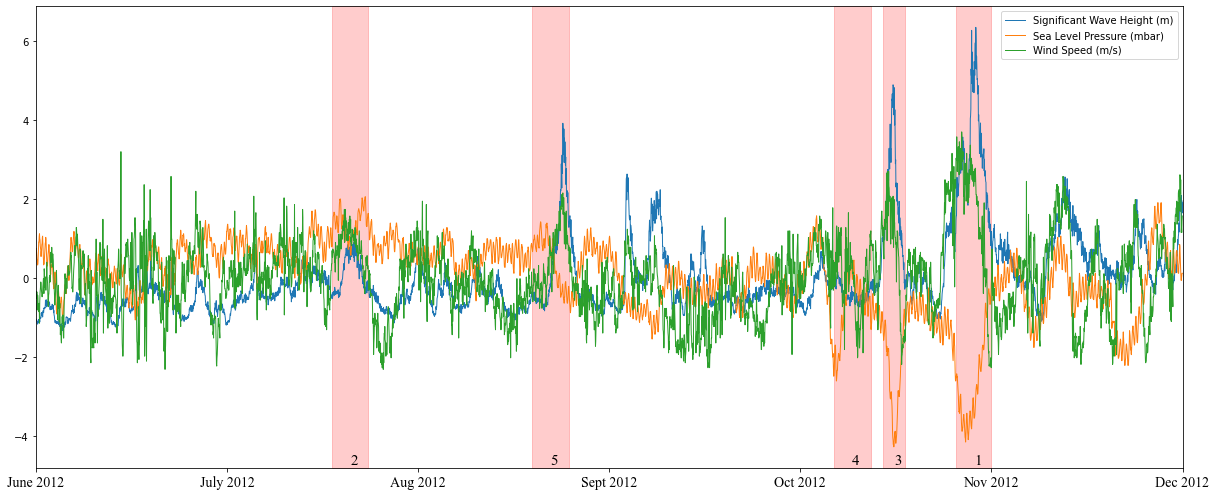

In [28]:
 print(final_) 
 plot_results(data_norm.T,intervals=global_intervals[:outlier_intervals_num],label=False)
 
 # save the results in csv file on the root directory
 final_.to_csv('interval_of_extreme_outliers.csv')
